# K‑Means Clustering — From Scratch

A **NumPy‑only** implementation of the classic **k‑Means** algorithm.  
We will:

1. Build a 2‑D toy dataset  
2. Code the full k‑Means loop (init → assignment → update)  
3. Track inertia to watch convergence  
4. Visualise final clusters and an *elbow* plot  


## 1. Quick Theory Recap

Given **k** centroids \( \{ \mu_1,\dots,\mu_k \} \) we minimise the **within‑cluster sum of squares**:

\[
\text{Inertia} = \sum_{i=1}^{N} \bigl\| \mathbf{x}_i - \mu_{c(i)} \bigr\|_2^2
\]

where \( c(i) \) is the index of the centroid closest to sample \( i \).

### Lloyd’s algorithm  

1. **Initialise** the k centroids (random samples or random points).  
2. **Assign step** – label each point with the index of the nearest centroid.  
3. **Update step** – move each centroid to the mean of points assigned to it.  
4. Repeat 2‑3 until assignments stop changing **or** inertia change < tolerance.


### 2. Imports & synthetic data

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# 2‑1. Reproducibility
np.random.seed(0)

# 2‑2. Three Gaussian blobs
N_PER = 150
centers = np.array([[0, 0], [5, 5], [-5, 5]])
cluster_std = [0.8, 1.0, 1.2]

X_list = []
for c, s in zip(centers, cluster_std):
    X_list.append(np.random.randn(N_PER, 2) * s + c)

X = np.vstack(X_list)          # shape (N, 2) with N = 450
print('Dataset shape:', X.shape)


Dataset shape: (450, 2)


### 3. Helper functions

In [2]:

def initialise_centroids(X, k):
    """Pick k random samples as the initial centroids."""
    idx = np.random.choice(len(X), k, replace=False)
    return X[idx].copy()

def assign_clusters(X, centroids):
    """Return array of cluster indices for each sample."""
    # Compute squared distances to each centroid
    # Broadcasting: X (N,2) -> (N,1,2), centroids (k,2) -> (1,k,2)
    dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(dists, axis=1)

def recompute_centroids(X, labels, k):
    """Compute new centroids as mean of assigned points."""
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        pts = X[labels == i]
        if len(pts) > 0:
            centroids[i] = pts.mean(axis=0)
        else:            # handle empty cluster by re‑init randomly
            centroids[i] = X[np.random.randint(len(X))]
    return centroids

def inertia(X, centroids, labels):
    """Sum of squared distances of points to their centroid."""
    return np.sum((X - centroids[labels]) ** 2)


### 4. Training k‑Means

In [3]:

k = 3                 # number of clusters
MAX_ITERS = 100
TOL = 1e-4            # stop if inertia improvement < TOL

# 4‑1. Initialise
centroids = initialise_centroids(X, k)
labels = assign_clusters(X, centroids)
prev_inertia = inertia(X, centroids, labels)

history = [prev_inertia]

for it in range(1, MAX_ITERS + 1):
    # Update step
    centroids = recompute_centroids(X, labels, k)
    # Assign step
    labels = assign_clusters(X, centroids)
    # Compute inertia
    cur_inertia = inertia(X, centroids, labels)
    history.append(cur_inertia)

    improvement = prev_inertia - cur_inertia
    print(f'iter {it:3d} | inertia = {cur_inertia:.2f} | improvement = {improvement:.4f}')

    if improvement < TOL:
        print('Converged.')
        break
    prev_inertia = cur_inertia


iter   1 | inertia = 4476.97 | improvement = 4131.5167
iter   2 | inertia = 4443.20 | improvement = 33.7646
iter   3 | inertia = 4437.30 | improvement = 5.9060
iter   4 | inertia = 4434.75 | improvement = 2.5472
iter   5 | inertia = 4433.94 | improvement = 0.8089
iter   6 | inertia = 4433.53 | improvement = 0.4122
iter   7 | inertia = 4432.37 | improvement = 1.1535
iter   8 | inertia = 4431.63 | improvement = 0.7397
iter   9 | inertia = 4431.07 | improvement = 0.5608
iter  10 | inertia = 4429.54 | improvement = 1.5342
iter  11 | inertia = 4428.12 | improvement = 1.4139
iter  12 | inertia = 4425.94 | improvement = 2.1868
iter  13 | inertia = 4416.42 | improvement = 9.5150
iter  14 | inertia = 4411.16 | improvement = 5.2656
iter  15 | inertia = 4405.35 | improvement = 5.8038
iter  16 | inertia = 4388.75 | improvement = 16.5990
iter  17 | inertia = 4356.30 | improvement = 32.4496
iter  18 | inertia = 4303.59 | improvement = 52.7112
iter  19 | inertia = 3890.54 | improvement = 413.0570
ite

### 5. Final clusters

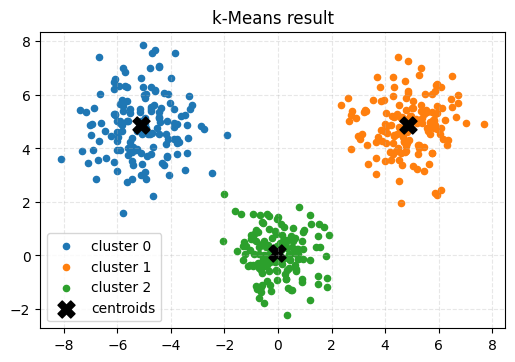

In [4]:

plt.figure(figsize=(6,6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(k):
    pts = X[labels == i]
    plt.scatter(pts[:,0], pts[:,1], s=20, color=colors[i % len(colors)], label=f'cluster {i}')
plt.scatter(centroids[:,0], centroids[:,1], color='k', marker='X', s=150, label='centroids')
plt.title('k‑Means result')
plt.legend()
plt.gca().set_aspect('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


### 6. Elbow method

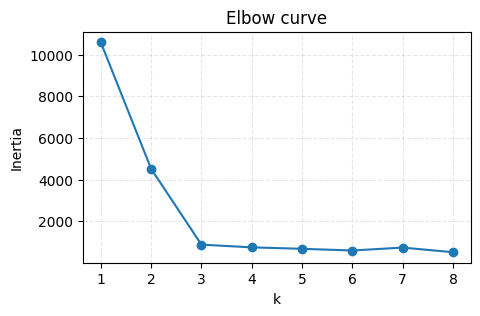

In [5]:

ks = range(1, 9)
inertias = []

for k_try in ks:
    c_init = initialise_centroids(X, k_try)
    lbls = assign_clusters(X, c_init)
    cent = recompute_centroids(X, lbls, k_try)
    prev = inertia(X, cent, lbls)
    # A mini training loop (few iterations) for each k
    for _ in range(15):
        cent = recompute_centroids(X, lbls, k_try)
        lbls = assign_clusters(X, cent)
        prev = inertia(X, cent, lbls)
    inertias.append(prev)

plt.figure(figsize=(5,3))
plt.plot(ks, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow curve')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


### 7. Next steps

* **k‑Means++ initialisation** – smarter seeding for faster convergence and better minima.  
* **Mini‑batch k‑Means** – scale to huge datasets by sampling.  
* **Different distance metrics** – cosine or Mahalanobis for specialised domains.  
* **Silhouette score** – another way to choose k without needing the elbow eye‑ball test.  
* **GMM / EM** – probabilistic soft‑clustering generalisation.
